In [10]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from modules.lifter_2d_3d.dataset.drive_and_act_keypoint_dataset import DriveAndActKeypointDataset
from modules.lifter_2d_3d.model.linear_model.lit_linear_model import LitSimpleBaselineLinear
from modules.lifter_2d_3d.model.jointformer.lit_jointformer import LitJointFormer
from modules.utils.visualization import (
    plot_samples
)
from experiments.experiment_config import (
    ALL_LIGHTNING_MODELS,
    DRIVE_AND_ACT_VIEWPOINTS,
    get_drive_and_act_loaders,
    two_actors_samples,
    four_actors_samples,
    driver_and_act_pretrained_map,
)

from IPython.display import display
from pathlib import Path


pl.seed_everything(1234)

# ------------
# dataset path
# ------------
dataset_root_path = Path('/root/data/processed/drive_and_act/')
keypoint_2d_path = dataset_root_path / 'keypoint_detection_results'
keypoint_3d_path = dataset_root_path / 'annotations'
# ------------
# model
# ------------
image_width = 1280
image_height = 1024
batch_size = 64
max_epoch = 200
val_check_period = 5
early_stopping_patience = 5
# ------------
# saved model path
# ------------
model_suffix = 'all_actor'

viewpoint = DRIVE_AND_ACT_VIEWPOINTS[0]
# pretrained_model_path = f'saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model_{model_suffix}'
# pretrained_model_path = './saved_lifter_2d_3d_model/drive_and_act/prediction/linear_model_all_actors'
percentages = [1, 2, 5, 10, 25, 50, 100]
# model_paths = [
#     # f'./saved_lifter_2d_3d_model/rq2/LitJointFormer/drive_and_act/{viewpoint}/single_actor/subset_{percentage}/vp1'
#         f'./saved_lifter_2d_3d_model/rq2/LitSimpleBaselineLinear/drive_and_act/{viewpoint}/single_actor/subset_{percentage}/vp1'
#     for percentage in percentages
# ]
model_paths = [
    # f'./saved_lifter_2d_3d_model/rq2/LitJointFormer/transfer_learning/{viewpoint}/single_actor/subset_{percentage}/vp1'
    f'./saved_lifter_2d_3d_model/rq2/LitSimpleBaselineLinear/transfer_learning/{viewpoint}/single_actor/subset_{percentage}/vp1'
    for percentage in percentages
]
pretrained_model_path = model_paths[-1]
with open(f'{pretrained_model_path}/best_model_path.txt', 'r') as f:
    checkpoint_path = f.readline()
print(checkpoint_path)
# saved_model_path = f'./saved_lifter_2d_3d_model/visualization'

Global seed set to 1234


saved_lifter_2d_3d_model/rq2/LitSimpleBaselineLinear/transfer_learning/a_column_co_driver/single_actor/subset_100/vp1/lightning_logs/version_0/checkpoints/epoch=49-step=17550.ckpt


test_dataset 10959


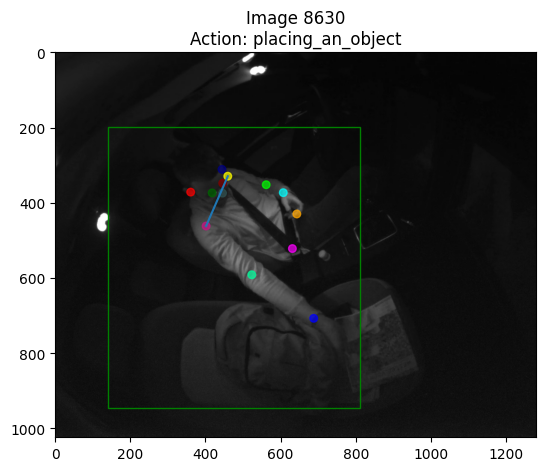

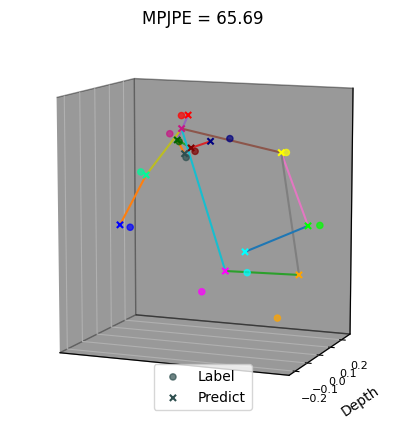

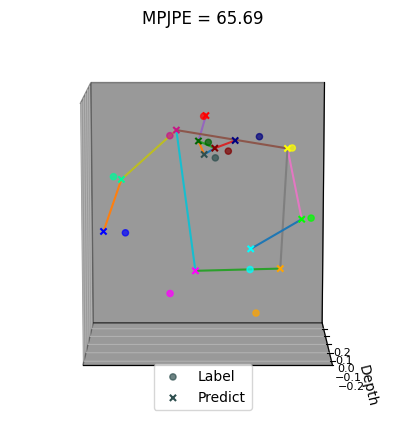

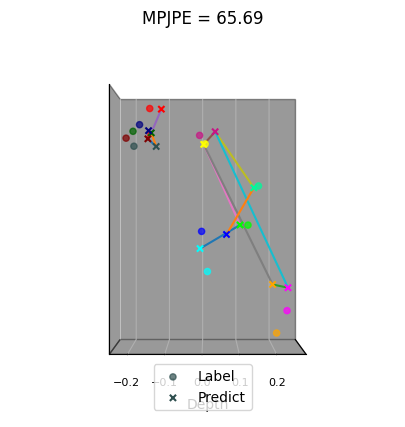

In [18]:
# lit_model = LitJointFormer(exclude_ankle=True, exclude_knee=True)
lit_model = LitSimpleBaselineLinear(exclude_ankle=True, exclude_knee=True)
lit_model = lit_model.load_from_checkpoint(checkpoint_path).to('cuda')
lit_model.eval()
lit_model.freeze()
constructed_loader = get_drive_and_act_loaders(viewpoint)

test_loader = constructed_loader['test_loader']

print(
    'test_dataset', len(test_loader.dataset)
)
model_checkpoint = ModelCheckpoint(monitor='val_loss',mode='min', save_top_k=1)
early_stopping = EarlyStopping(monitor="val_loss", mode="min", patience=early_stopping_patience)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# saved_model_path = f'./saved_lifter_2d_3d_model/drive_and_act/pretrained/synthetic_cabin_ir/full/linear_model_{model_suffix}'
# if not os.path.exists(saved_model_path):
#     os.makedirs(saved_model_path)
# trainer = pl.Trainer(enable_checkpointing=False)
# trainer.test(model=lit_model, ckpt_path=checkpoint_path, dataloaders=test_loader)
plot_samples(
    dataset_root_path / viewpoint,
    lit_model,
    test_loader,
    'train',
    img_figsize=(20/2, 10/2),
    plot_figsize=(20.5/2, 10/2),
    sample_indices=[1000],
    # sample_indices=[500],
    is_plot_gt_skeleton=False
)